In [1]:
import pickle
import numpy as np
import pandas as pd
import seaborn as sns
import networkx as nx
import matplotlib as mpl
import matplotlib.pyplot as plt
from module import MyClass
import module.plotlib as plotlib
import seaborn as sns
plotlib.update_settings(usetex=True)
%config InlineBackend.figure_format = 'svg'
%load_ext autoreload
%autoreload 2

Create color map

In [2]:
from matplotlib.colors import ListedColormap
colors = []
colors.append(mpl.colors.to_rgb('#4666FF'))
colors.append((0.8833417, 0.19830556, 0.26014181))
colors.append(mpl.colors.to_rgb('#FFA347'))
colors.append(mpl.colors.to_rgb('#989898'))
colors.append(mpl.colors.to_rgb('#FFE047'))
colors.append(mpl.colors.to_rgb('#9966CC'))
colors.append(mpl.colors.to_rgb('#26428B'))
colors.append(mpl.colors.to_rgb('#9BC4E2'))

In [3]:
avg_approxr_amp = []
avg_approxr_dep = []
avg_approxr_z = []
avg_approxr = []

avg_var_amp = []
avg_var_dep = []
avg_var_z = []
avg_var = []

# Number of points
pts = 13
# List with noise levels
lst = np.linspace(0,.25,pts)
# Loop over all instances
for idx in range(30):
    # Path
    path = "../../data/max_cut_" + str(idx) + "/"
    # Load graph
    graph = nx.readwrite.gpickle.read_gpickle(path + "graph")
    # Load variances
    var_z = pickle.load(open(path + "thermal_variance_dephasing","rb"))
    var_dep = pickle.load(open(path + "thermal_variance_depolarizing","rb"))
    var_amp = pickle.load(open(path + "thermal_variance_equal_error_amplitude_damping","rb"))
    
    # Create object
    obj = MyClass(graph)
    # Find the optimal cost
    cost_min = min(obj.cost)
    # Create mixed state
    rho = np.diag(obj.mixed_state())
    # Initialize list
    approxr_dep = []

    # Loop over different noise levels
    for p in lst:
        # Calculate the mitigated cost
        mitigated_cost = obj.mitigated_cost(rho, p)
        # Calculate the approximation ratio for depolarizing noise
        # and append it to array
        approxr_dep.append(mitigated_cost / cost_min)

    approxr_amp = pickle.load(open(path + "thermal_equal_error_amplitude_damping","rb"))
    approxr_amp = [float(approxr_amp[str(i)][1].real / cost_min) for i in range(pts)]
    # Append to array
    avg_approxr_amp.append(approxr_amp)

    # Append to array
    avg_approxr_dep.append(approxr_dep)
    
    # Calculate the mitigated approximation ratio for dephasing noise
    approxr_z = obj.mitigated_cost(rho) / cost_min
    avg_approxr_z.append(approxr_z)

    # Calculate the unmitigated approximation ratio
    approxr = obj.unmitigated_cost(rho) / cost_min
    avg_approxr.append(approxr)

    # Append the depolarzing variance
    var_amp = [var_amp[str(i)][1] for i in range(pts)]
    avg_var_amp.append(var_amp)

    # Append the dephasing variance
    var_z = [var_z[str(i)][1] for i in range(pts)]
    avg_var_z.append(var_z)

    # Append the depolarzing variance
    var_dep = [var_dep[str(i)][1] for i in range(pts)]
    avg_var_dep.append(var_dep)
    
    # Append the unmitigated variance
    var = obj.unmitigated_variance(rho)
    avg_var.append(var)

In [4]:
# Calculate the average over all instances
avg_approxr_amp = np.mean(avg_approxr_amp, axis=0)
avg_approxr_dep = np.mean(avg_approxr_dep, axis=0)
avg_approxr_z = np.mean(avg_approxr_z)
avg_approxr = np.mean(avg_approxr)

avg_var_amp = np.mean(avg_var_amp, axis=0)
avg_var_dep = np.mean(avg_var_dep, axis=0)
avg_var_z = np.mean(avg_var_z, axis=0)
avg_var = np.mean(avg_var)

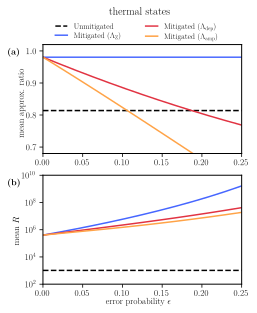

In [5]:
"""Save a figure"""
fig, ax = plotlib.create_fig(single_col=True,nrows=2)

"""Third plot"""
ax[0].plot(lst, avg_approxr * np.ones(pts),
        label=r'Unmitigated',color='k',linestyle='--')
"""First plot"""
ax[0].plot(lst, avg_approxr_z * np.ones(pts),'-',
           label=r'Mitigated ($\Lambda_\text{Z}$)',color=colors[0])
"""Second plot"""
ax[0].plot(lst, avg_approxr_dep,'-',
            label=r'Mitigated ($\Lambda_\text{dep}$)',color=colors[1])
"""Second plot"""
ax[0].plot(lst, avg_approxr_amp,'-',
            label=r'Mitigated ($\Lambda_\text{amp}$)',color=colors[2])

plotlib.add_label(ax[0],x0=0.18,text='(a)')

"""Labels, Ticks and Legens"""
ax[0].set_yticks([.6,.7,.8,.9,1])
ax[0].set_ylim([0.68,1.02])
ax[0].set_ylabel(r'mean approx. ratio');
ax[0].set_title(r'thermal states', pad=30);
ax[0].set_xlim([0,.25])
ax[0].legend(loc="upper center", frameon=False, framealpha=1, ncol=2, fontsize=8, bbox_to_anchor=(0.5,1.25))

ax[0].tick_params(axis="x", direction="out", which='major')
ax[0].tick_params(axis="y", direction="out")
ax[0].tick_params(right=False, top=False)

""""""""""""""""""""""""
threshold = 1e-3

"""Third plot"""
ax[1].semilogy(lst, avg_var * np.ones(pts) / threshold / 2,
        label=r'Unmitigated',color='k',linestyle='--')
"""First plot"""
ax[1].semilogy(lst, avg_var_z / threshold,'-',
           label=r'Mitigated ($\Lambda_\text{Z}$)',color=colors[0])
"""Second plot"""
ax[1].semilogy(lst, avg_var_dep / threshold,'-',
            label=r'Mitigated ($\Lambda_\text{dep}$)',color=colors[1])
"""Second plot"""
ax[1].semilogy(lst, avg_var_amp / threshold,'-',
            label=r'Mitigated ($\Lambda_\text{amp}$)',color=colors[2])

plotlib.add_label(ax[1],x0=0.18,text='(b)')

"""Labels, Ticks and Legens"""
ax[1].set_xlabel(r'error probability $\epsilon$');
ax[1].set_ylim([1e2,1e10])
ax[1].set_xlim([0,.25])
ax[1].set_ylabel(r'mean $R$');
#ax[1].legend(loc="best", frameon=False, framealpha=1, ncol=1, fontsize=8)

ax[1].tick_params(axis="x", direction="out", which='major')
ax[1].tick_params(axis="y", direction="out")
ax[1].tick_params(right=False, top=False)

In [9]:
fig.savefig("../../figures/fig-thermal.pdf",
            bbox_inches='tight',
            pad_inches=0.1)